In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline

In [ ]:
df = pd.read_csv('test_2020.csv')
df.head()

### Чистка

In [ ]:
df = df[df.columns[~pd.Series(df.columns).str.startswith('var')]]

In [ ]:
df = df[df.idn != 1000]

In [ ]:
df = df.iloc[:,:-1]

In [61]:
df.head()

,idn,a02_trad,a03_sum,a04_cosm,a1_1,a10_1,a11a_1,a11b_1,a11c_1,a12_1,...,n30_13,n31_13,n32_13,n33_13,n4_13,n5_13,n6_13,n7_13,n8_13,n9_13
0,1,Bushmen,60,36,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Khoikhoi,71,22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Xhosa,64,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,"Zulu,Swasi",55,19,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,"Sotho, Tswana",75,19,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Проверим, сколько мифов с одинаковыми значениями

In [62]:
df.duplicated(subset=df.columns[2:], keep = False).sum()

0

In [63]:
df.duplicated(subset=df.columns[4:], keep = False).sum()

0

In [ ]:
df.shape

То есть все строки в чем-то между собой различаются

In [ ]:
df.e31a2_11 = df.e31a2_11.str.replace(" ",'0')
df.k136d_10 = df.k136d_10.str.replace(" ",'0')
df.k72a_10 = df.k72a_10.str.replace(" ",'0')
df.L72i_10 = df.L72i_10.str.replace(" ",'0')
df.m114b1_11 = df.m114b1_11.str.replace(" ",'0')
df.m39a5a2_11 = df.m39a5a2_11.str.replace(" ",'0')


In [ ]:
df = df.fillna('0')
for i in df.iloc[:, 2:].columns:
    print(i)
    df.loc[:,i] = df.loc[:,i].astype(int)

### W2V

In [ ]:
import numpy as np

class word2vec_model():
    #settings
    def __init__(self, window_size, embedding_size, epochs, learning_rate):
        self.window = window_size
        self.embedding_size = embedding_size
        self.epochs = epochs
        self.lr = learning_rate

    #text to one-hot representation
    def prepare_data(self, df):
        counts = dict()
#         tokens = [word.lower() for word in data.split()]
#         print('tokens', tokens)
#         for word in tokens:
#             if word in counts:
#                 counts[word] += 1
#             else:
#                 counts[word] = 1
        self.vocab_size = df.drop(columns=['idn','a02_trad']).iloc[:,:15].shape[1]#num of uniq rows 
        self.word_index = dict((str(row[2:].values), row.idn) for index, row in df.iterrows())#index of myth: feature
        self.index_word = dict((str(row[2:].values), row.idn) for index, row in df.iterrows())#feature : index of myth
#         print(self.index_word)      
        training_data = []
        df = df.drop(columns=['idn','a02_trad']).iloc[:,:15]
        for i, row in df.iterrows():
            w_target = df.iloc[i].values.tolist()
            w_context = []
            for j in range(i - self.window, i + self.window+1):
                if j != i and j <= df.shape[0]-1 and j >= 0:
#                     w_context += [df.iloc[j].values.tolist()]
                    w_context.append(df.iloc[j].values.tolist())
            training_data.append([w_target, w_context])
#             training_data += list(w_target)
#             training_data += list(w_context)
        
        print('train data', len(training_data))
        return np.array(training_data)
    
    #single word to one-hot vector of vocab_size
#     def get_onehot(self, word):
#         word_vec = [0 for i in range(0, self.vocab_size)]
#         word_index = self.word_index[word]
#         word_vec[word_index] = 1
#         return word_vec
    
    #initialize weights and train for n epochs
    def train(self, data):
        training_data = self.prepare_data(data)
        history = []
        self.w1 = np.random.rand(self.vocab_size,self.embedding_size)
        self.w2 = np.random.rand(self.embedding_size,self.vocab_size) 
        for i in range(self.epochs):
            self.loss = 0
            for w_t, w_c in training_data:
                print(w_t)
                print(w_c)
                y_pred, h, u = self.forward_pass(w_t)            
                error = np.sum([np.subtract(y_pred, word) for word in w_c], axis=0)
                self.backward_pass(error, h, w_t)
                self.loss += -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u)))
            history.append(self.loss)
            #print('epoch: %d, loss: %.5f' % (i,self.loss))
        return history
    
    #calculate hidden layer values, weights and outupts
    def forward_pass(self, x):
        print(self.w1.shape, len(x))
        h = np.dot(self.w1.T, x)
        u = np.dot(self.w2.T, h)
        y_c = self.softmax(u)
        return y_c, h, u
    
    #backpropagation for weight updating
    def backward_pass(self, e, h, x):
        dl_dw2 = np.outer(h, e)
        dl_dw1 = np.outer(x, np.dot(self.w2, e.T))
        self.w1 = self.w1 - (self.lr * dl_dw1)
        self.w2 = self.w2 - (self.lr * dl_dw2)
    
    #softmax for regression
    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)
    
    #get single embedding for a word
    def get_vec(self, word):
        w_index = self.word_index[word]
        v_w = self.w1[w_index]
        return v_w
    
    #get embedding dictionary
    def get_vec_dict(self):
        return dict((self.index_word[i], emb) for i, emb in enumerate(self.w1))
    
def train(data):
    model = word2vec_model(window_size=6, embedding_size=10, epochs=100, learning_rate=0.01)
    model.train(data)
    return model.get_vec_dict()

In [ ]:
# doc = "After the deduction of the costs of investing, " \
#       "beating the stock market is a loser's game."

model = word2vec_model(window_size=3, embedding_size=10, epochs=100, learning_rate=0.01)
model.train(df)

len(model.w1)

Идея - взять тот вектор, что у нас уже есть

Проблема - нет охе, из-за этого лосс не вычисляется

Решение - перевести числа в строки и запустить охе?

Решение2 - хэшинг трик на числах?

### PCA

In [ ]:
df

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


x = df.iloc[:, 2:].astype(int).values

x = StandardScaler().fit_transform(x)


pca = PCA(n_components=0.9)
x_pca = pca.fit_transform(x)

x_pca.shape



### SVD

In [ ]:
from numpy.linalg import svd

n = 20 # Singular Values
U, s, V = svd(x)
Sig = np.mat(np.eye(n)*s[:n])
newdata = U[:,:n]

In [ ]:
newdata

### TSNE

In [ ]:
from sklearn.manifold import TSNE

X_tsne = TSNE(learning_rate=100,).fit_transform(x)

In [ ]:
X_tsne

### UMAP

In [ ]:
!pip install umap-learn

In [ ]:
import umap

### Косинусная близость

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(x)
print('pairwise dense output:\n {}\n'.format(similarities))
similarities.shape

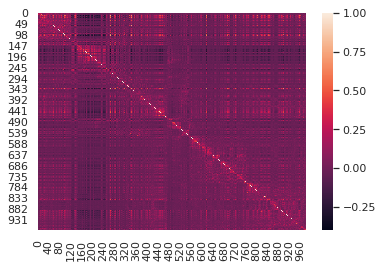

In [50]:
import seaborn as sns; sns.set()

ax = sns.heatmap(similarities)

### Kmeans

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



inertia = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(x)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 25), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

Text(0,0.5,'$J(C_k)$')

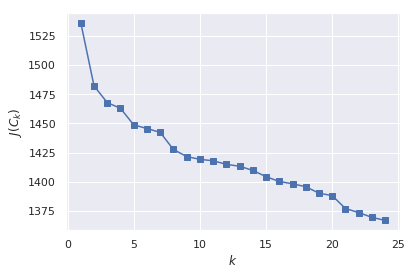

In [51]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



inertia = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(x_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 25), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

до 8 кластеров можно попробовать

In [ ]:
km = KMeans(n_clusters=2)
idx = km.fit(x_pca)
clusters = km.labels_.tolist()
print (km.labels_)



In [ ]:
df.head()

In [ ]:
df_km = pd.concat([df.iloc[:,:2],pd.Series(km.labels_, name = 'km_label'), pd.DataFrame(x_pca[:,:2], columns=['pca1','pca2'])], axis = 1)

In [ ]:
from matplotlib import rc
#включаем русские символы на графике
font = {'family' : 'Verdana', 'weight': 'normal', 'size'   : 22}
rc('font', **font)

#можно сгенерировать цвета для кластеров
# import random
# def generate_colors(n):
#     color_list = []
#     for c in range(0,n):
#         r = lambda: random.randint(0,255)
#         color_list.append( '#%02X%02X%02X' % (r(),r(),r()) )
#     return color_list

cluster_names = dict((x, str(x+1)) for x in range(8))


fig, ax = plt.subplots(figsize=(72, 36))

groups = df_km.groupby('km_label')

for name, group in groups:
    ax.plot(group.pca1, group.pca2, marker='o', linestyle='', ms=22, mec='none', label=cluster_names[name],
           alpha=0.7)
    ax.set_aspect('auto')
    ax.tick_params(        axis= 'x',          
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(        axis= 'y',         
        which='both',     
        left='off',      
        top='off',       
        labelleft='off')
    
ax.legend(numpoints=1)  #показать легенду только 1 точки

# #добавляем метки/названия в х,у позиции с поисковым запросом
# for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=22)  
fig.suptitle('Kmeans+PCA', fontsize=38)
# fig.savefig('answ2_pca.jpg')
#показать график
plt.show() 
plt.close()

In [ ]:
def plot_emd(method:str, data, n_clusters:int = 8):
    km = KMeans(n_clusters=n_clusters)
    idx = km.fit(data)
    clusters = km.labels_.tolist()
#     print (km.labels_)

    df_km = pd.concat([df.iloc[:,:2],pd.Series(km.labels_, name = method+'_label'), 
                       pd.DataFrame(x_pca[:,:2], columns=[method+'1',method+'2'])], axis = 1)
    
    cluster_names = dict((x, str(x+1)) for x in range(8))


    fig, ax = plt.subplots(figsize=(40, 20))

    groups = df_km.groupby(method+'_label')

    for name, group in groups:
        ax.plot(group[method+'1'], group[method+'2'], marker='o', linestyle='', ms=22, mec='none', 
                label=cluster_names[name],
                alpha=0.7)
        ax.set_aspect('auto')
        ax.tick_params(        axis= 'x',          
            which='both',      
            bottom='off',      
            top='off',         
            labelbottom='off')
        ax.tick_params(        axis= 'y',         
            which='both',     
            left='off',      
            top='off',       
            labelleft='off')

    ax.legend(numpoints=1)  #показать легенду только 1 точки

    # #добавляем метки/названия в х,у позиции с поисковым запросом
    # for i in range(len(df)):
    #    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=22)  
    fig.suptitle('Kmeans+'+method, fontsize=38)
    # fig.savefig('answ2_pca.jpg')
    #показать график
    plt.show() 
    plt.close()
    
    return df_km

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 

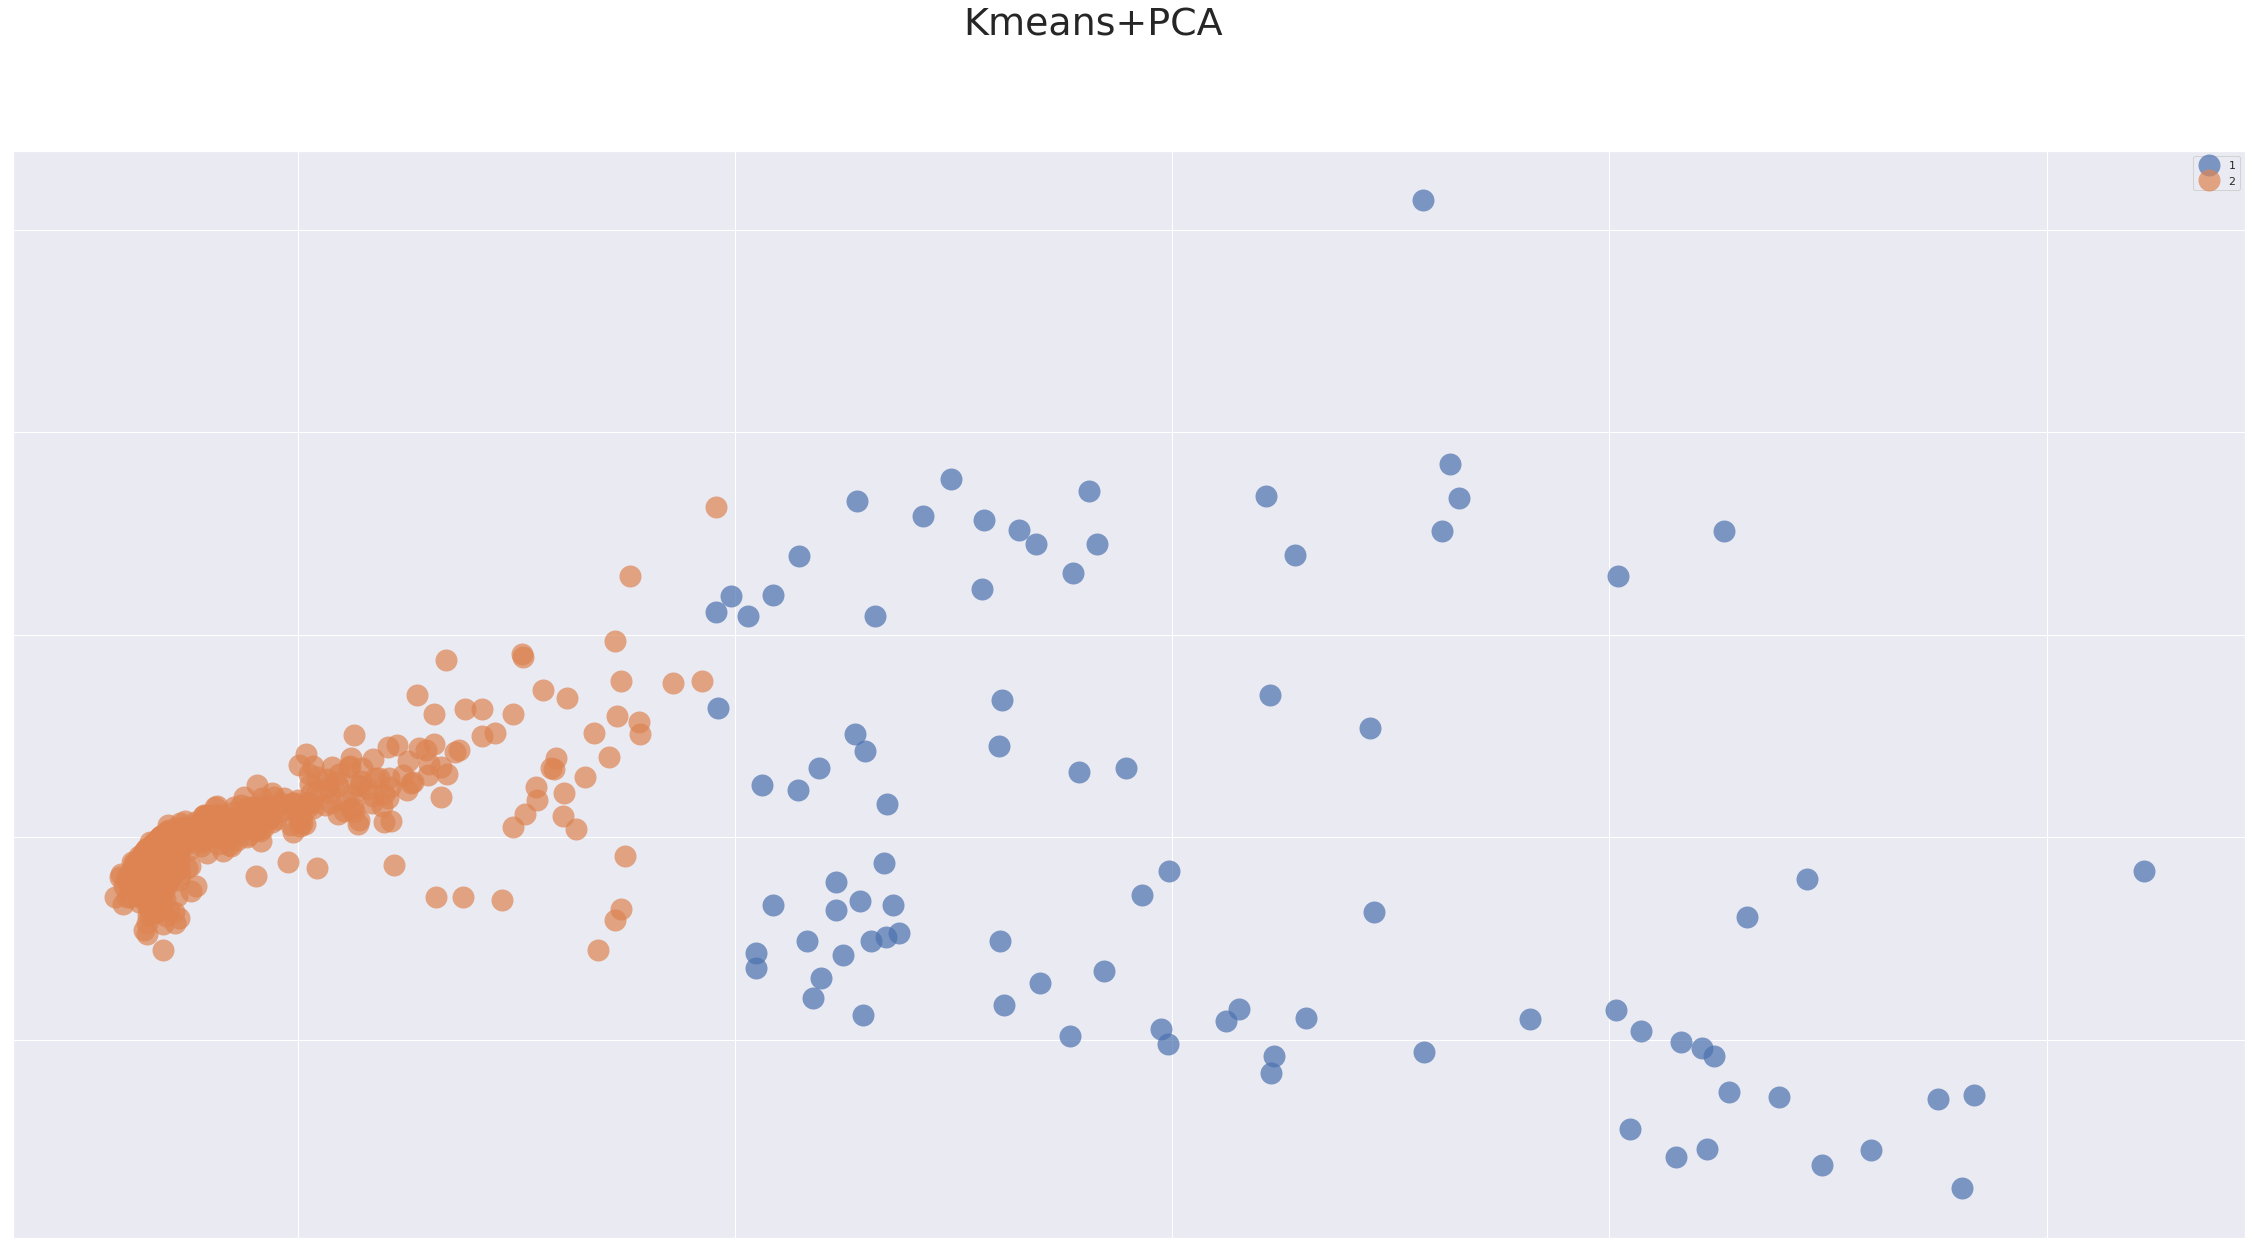

,idn,a02_trad,PCA_label,PCA1,PCA2
0,1,Bushmen,1,-5.449046,0.559562
1,2,Khoikhoi,1,-3.131956,0.176222
2,3,Xhosa,1,-2.762295,-0.220902
3,4,"Zulu,Swasi",1,-4.039606,0.922487
4,5,"Sotho, Tswana",1,-2.250557,0.248442
5,6,"Tonga, Ndebele",1,-3.894768,0.993513
6,7,Shona,1,-1.764166,1.218162
7,8,"Bemba,Kaonde,Lamba",1,-4.446332,1.045217
8,9,"Tsonga,Soli,Sala,Lenje",1,-3.599328,0.659439
9,10,Ila,1,-5.776440,0.328016


In [52]:
plot_emd('PCA',x_pca,2)

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 

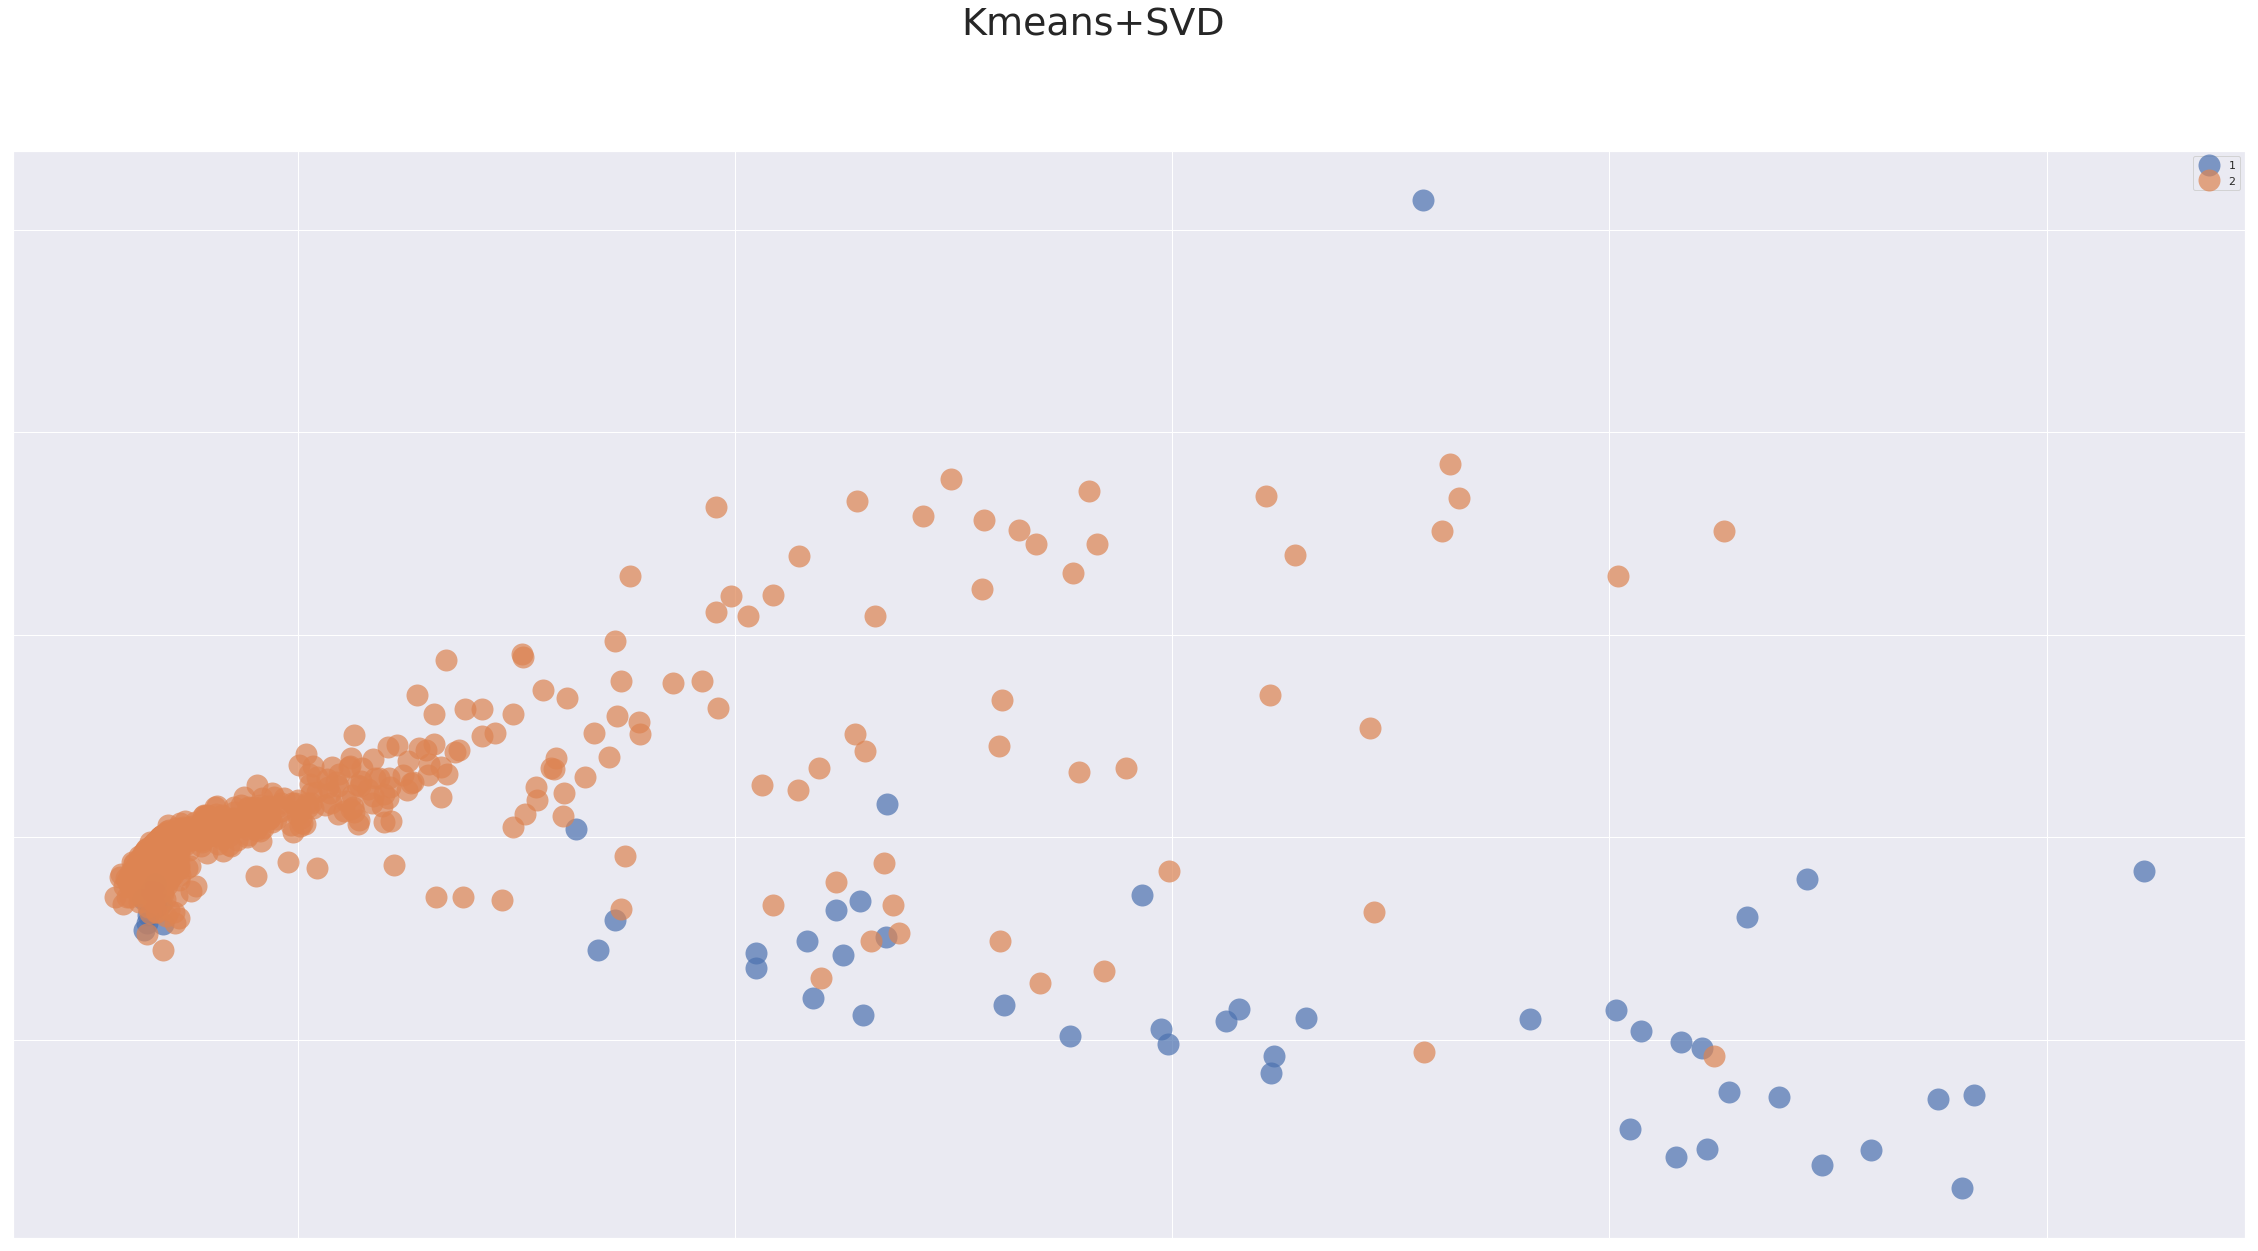

,idn,a02_trad,SVD_label,SVD1,SVD2
0,1,Bushmen,1,-5.449046,0.559562
1,2,Khoikhoi,1,-3.131956,0.176222
2,3,Xhosa,1,-2.762295,-0.220902
3,4,"Zulu,Swasi",1,-4.039606,0.922487
4,5,"Sotho, Tswana",1,-2.250557,0.248442
5,6,"Tonga, Ndebele",1,-3.894768,0.993513
6,7,Shona,1,-1.764166,1.218162
7,8,"Bemba,Kaonde,Lamba",1,-4.446332,1.045217
8,9,"Tsonga,Soli,Sala,Lenje",1,-3.599328,0.659439
9,10,Ila,1,-5.776440,0.328016


In [57]:
plot_emd('SVD',newdata,2)

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 

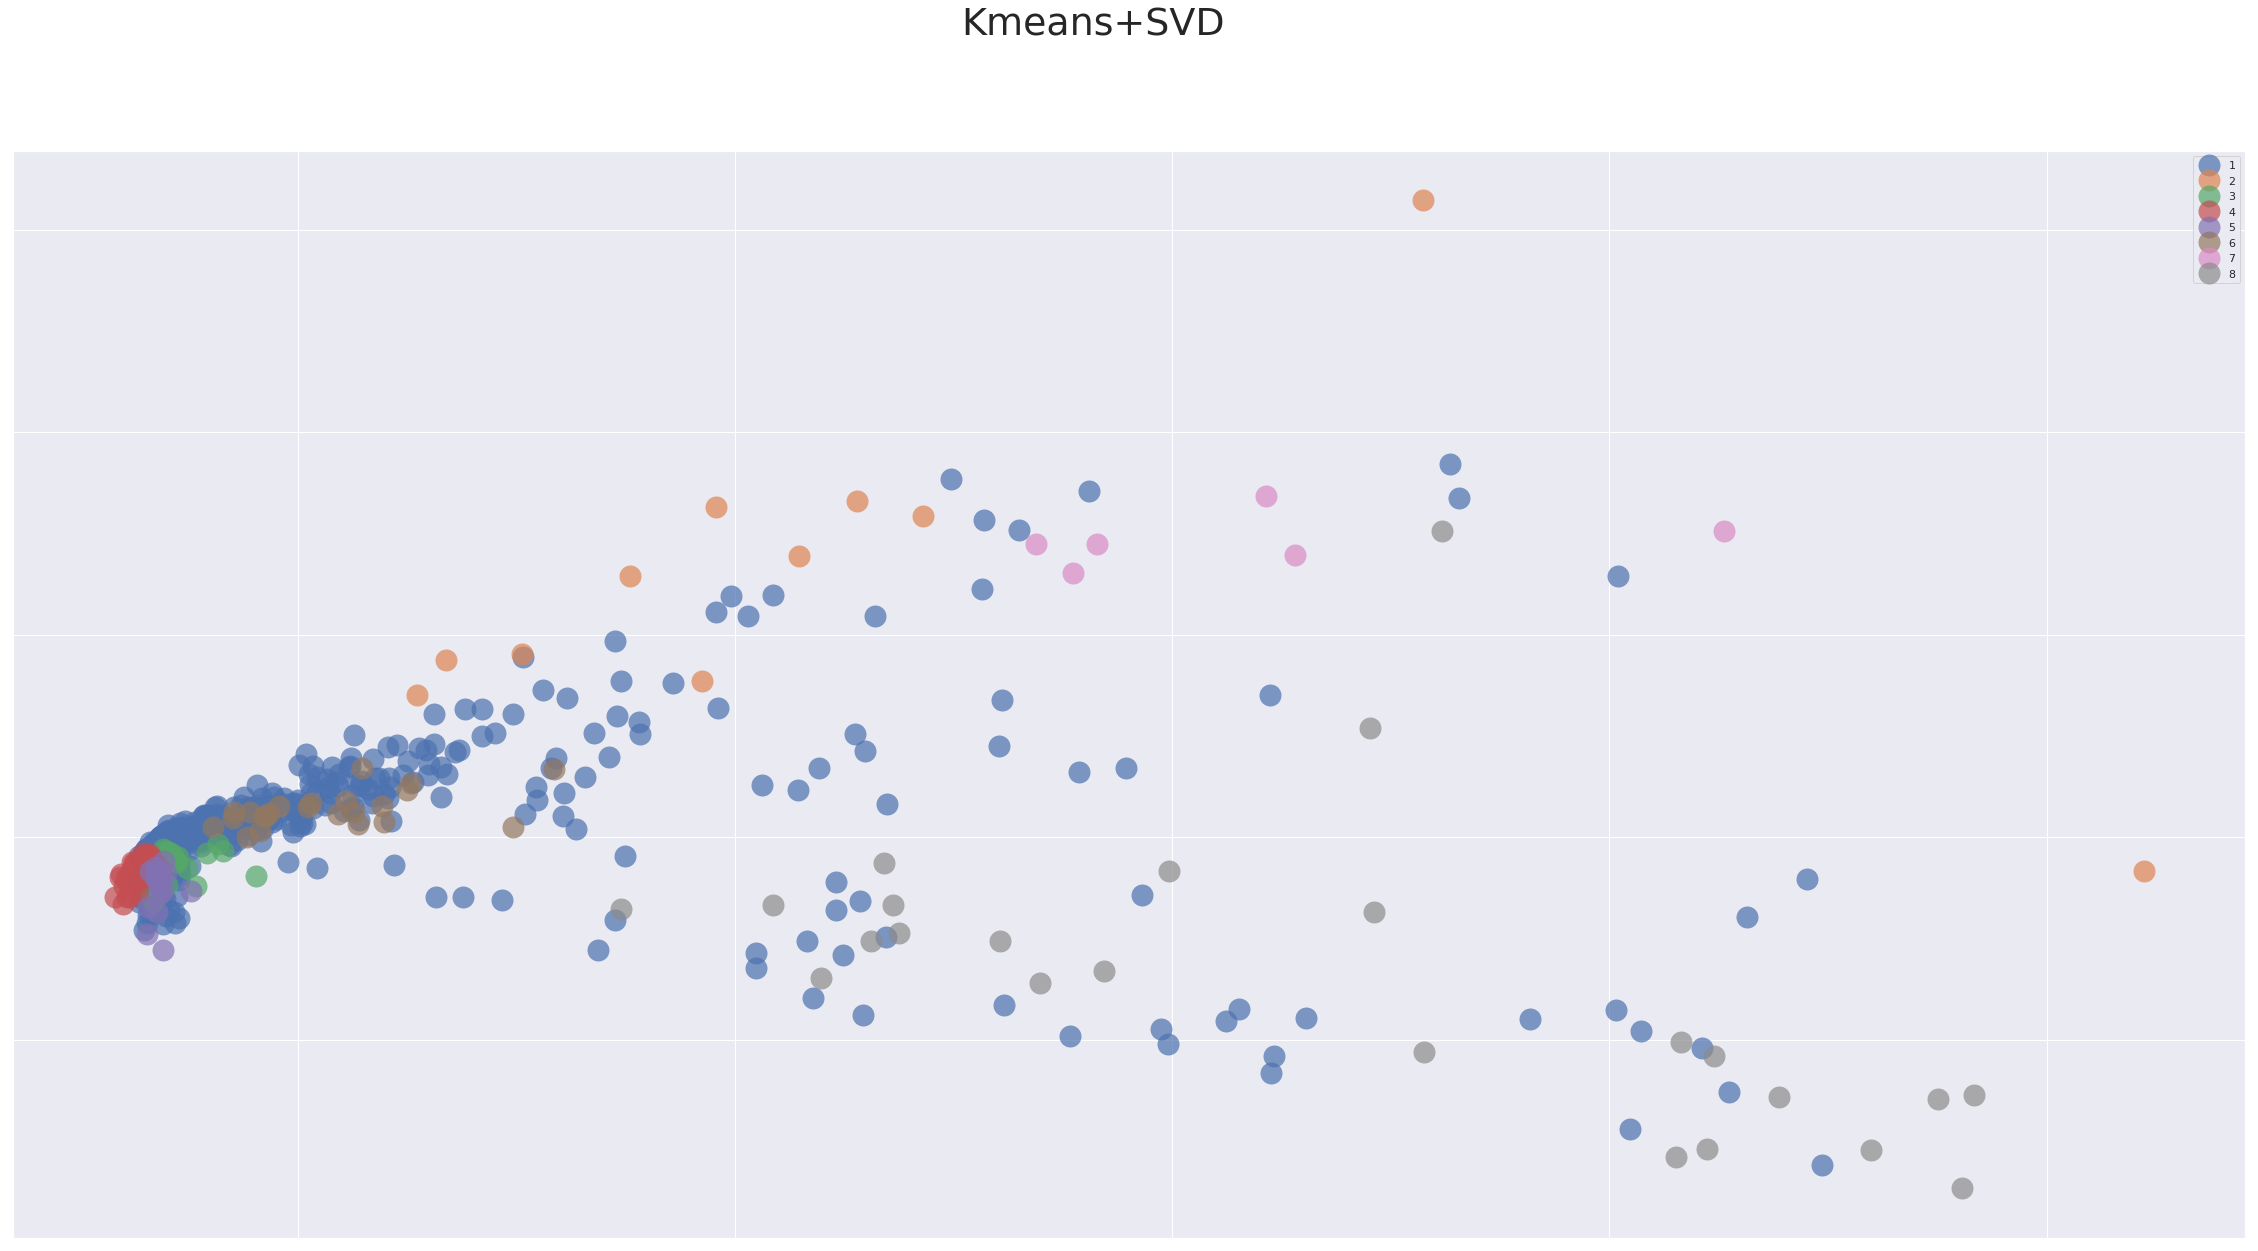

,idn,a02_trad,SVD_label,SVD1,SVD2
0,1,Bushmen,0,-5.449046,0.559562
1,2,Khoikhoi,0,-3.131956,0.176222
2,3,Xhosa,0,-2.762295,-0.220902
3,4,"Zulu,Swasi",0,-4.039606,0.922487
4,5,"Sotho, Tswana",0,-2.250557,0.248442
5,6,"Tonga, Ndebele",0,-3.894768,0.993513
6,7,Shona,0,-1.764166,1.218162
7,8,"Bemba,Kaonde,Lamba",0,-4.446332,1.045217
8,9,"Tsonga,Soli,Sala,Lenje",0,-3.599328,0.659439
9,10,Ila,0,-5.776440,0.328016


In [58]:
plot_emd('SVD',newdata,8)

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 

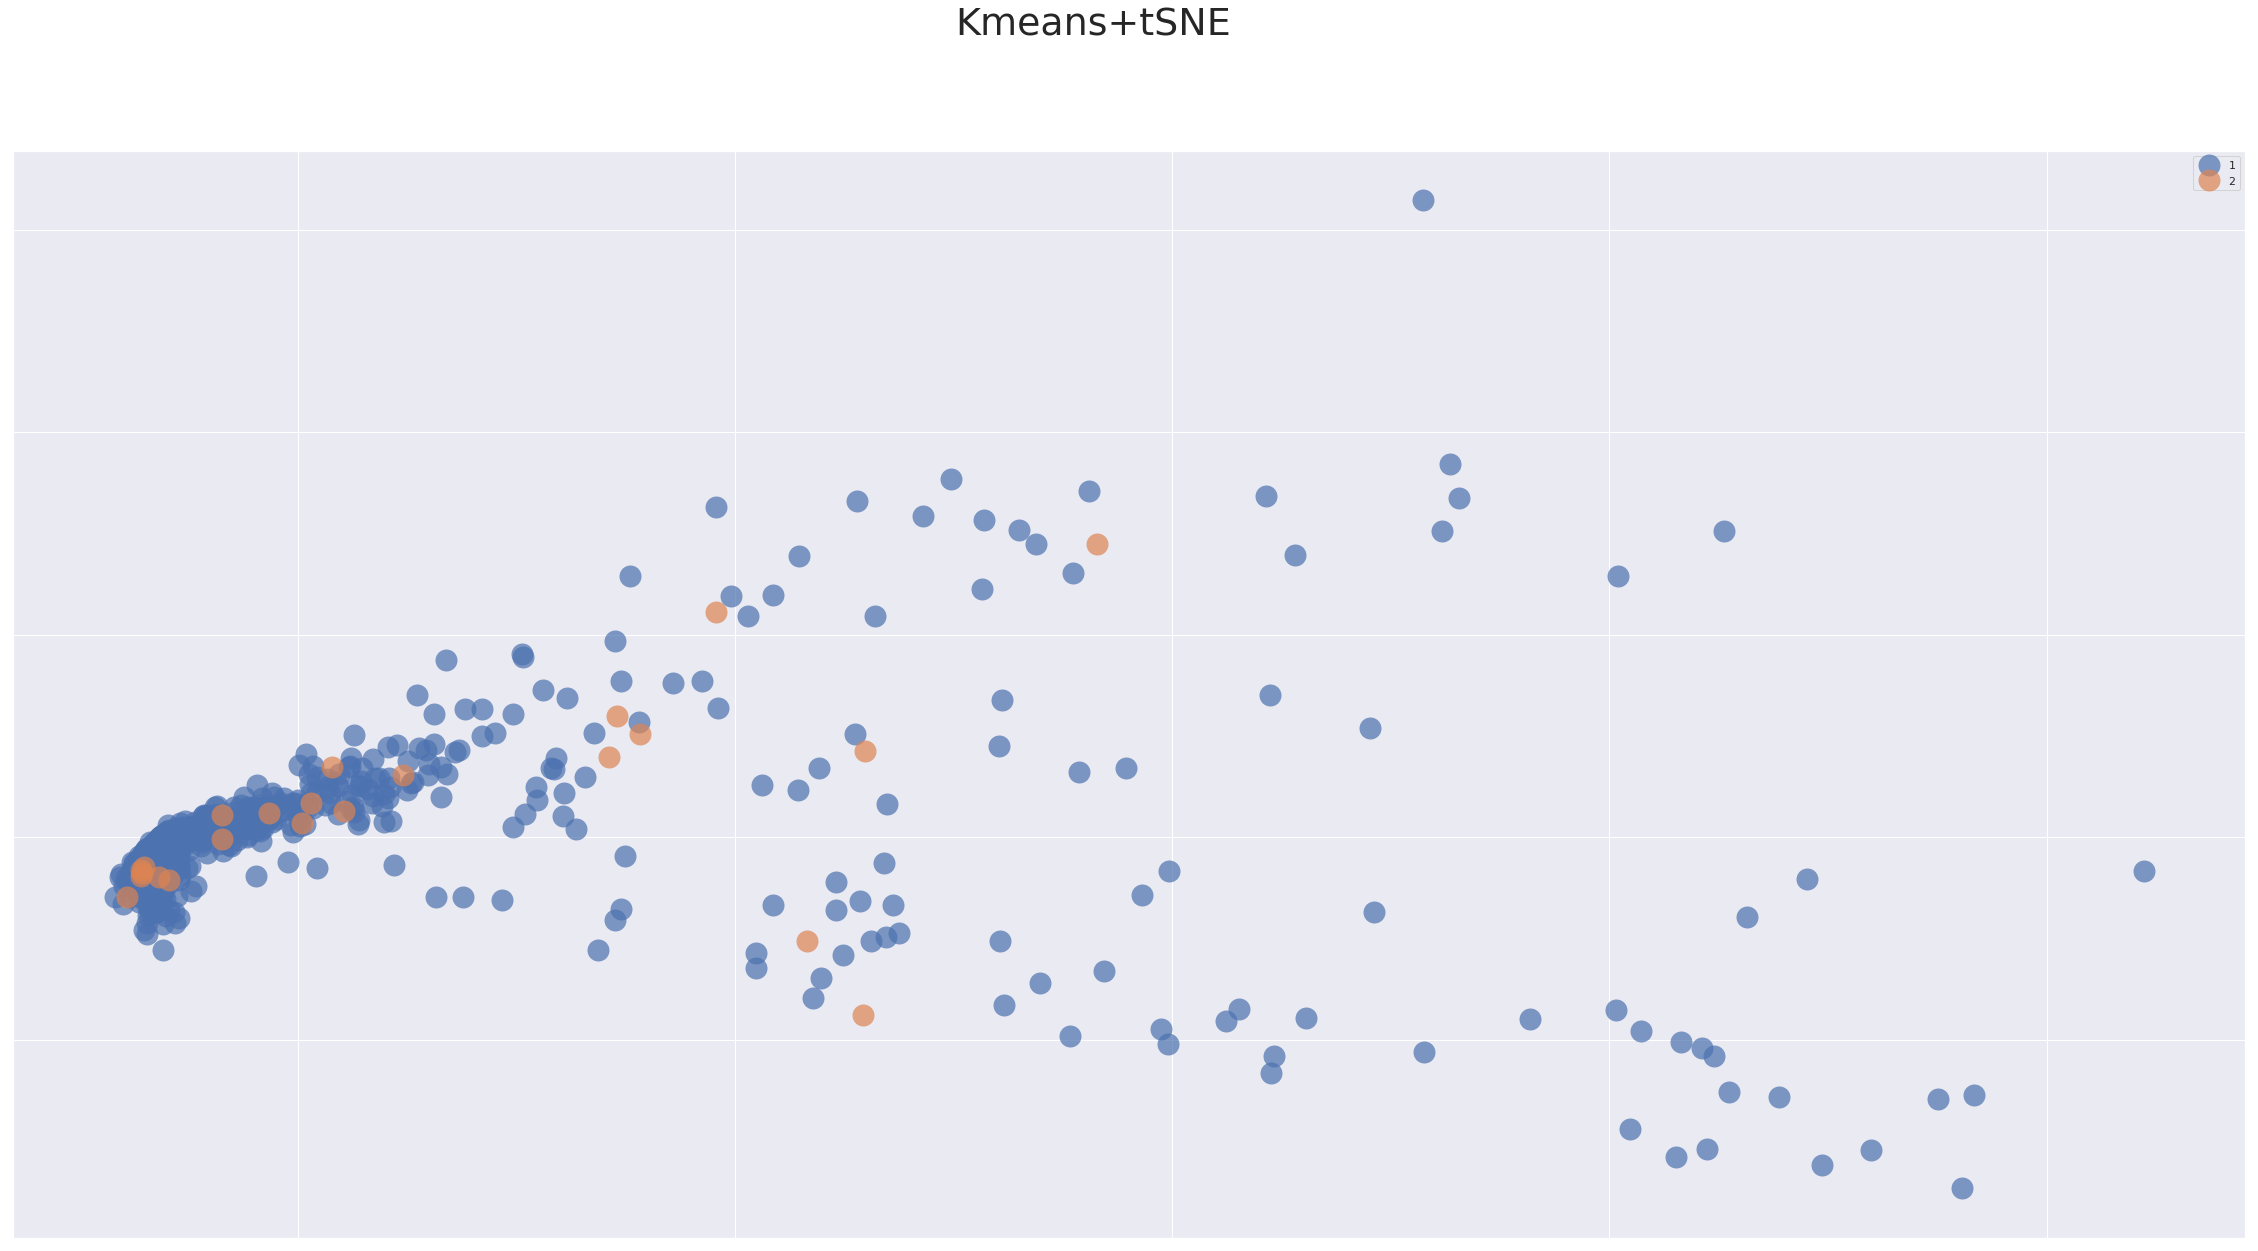

,idn,a02_trad,tSNE_label,tSNE1,tSNE2
0,1,Bushmen,0,-5.449046,0.559562
1,2,Khoikhoi,0,-3.131956,0.176222
2,3,Xhosa,0,-2.762295,-0.220902
3,4,"Zulu,Swasi",0,-4.039606,0.922487
4,5,"Sotho, Tswana",0,-2.250557,0.248442
5,6,"Tonga, Ndebele",0,-3.894768,0.993513
6,7,Shona,0,-1.764166,1.218162
7,8,"Bemba,Kaonde,Lamba",0,-4.446332,1.045217
8,9,"Tsonga,Soli,Sala,Lenje",0,-3.599328,0.659439
9,10,Ila,0,-5.776440,0.328016


In [53]:
plot_emd('tSNE',X_tsne,2)

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 

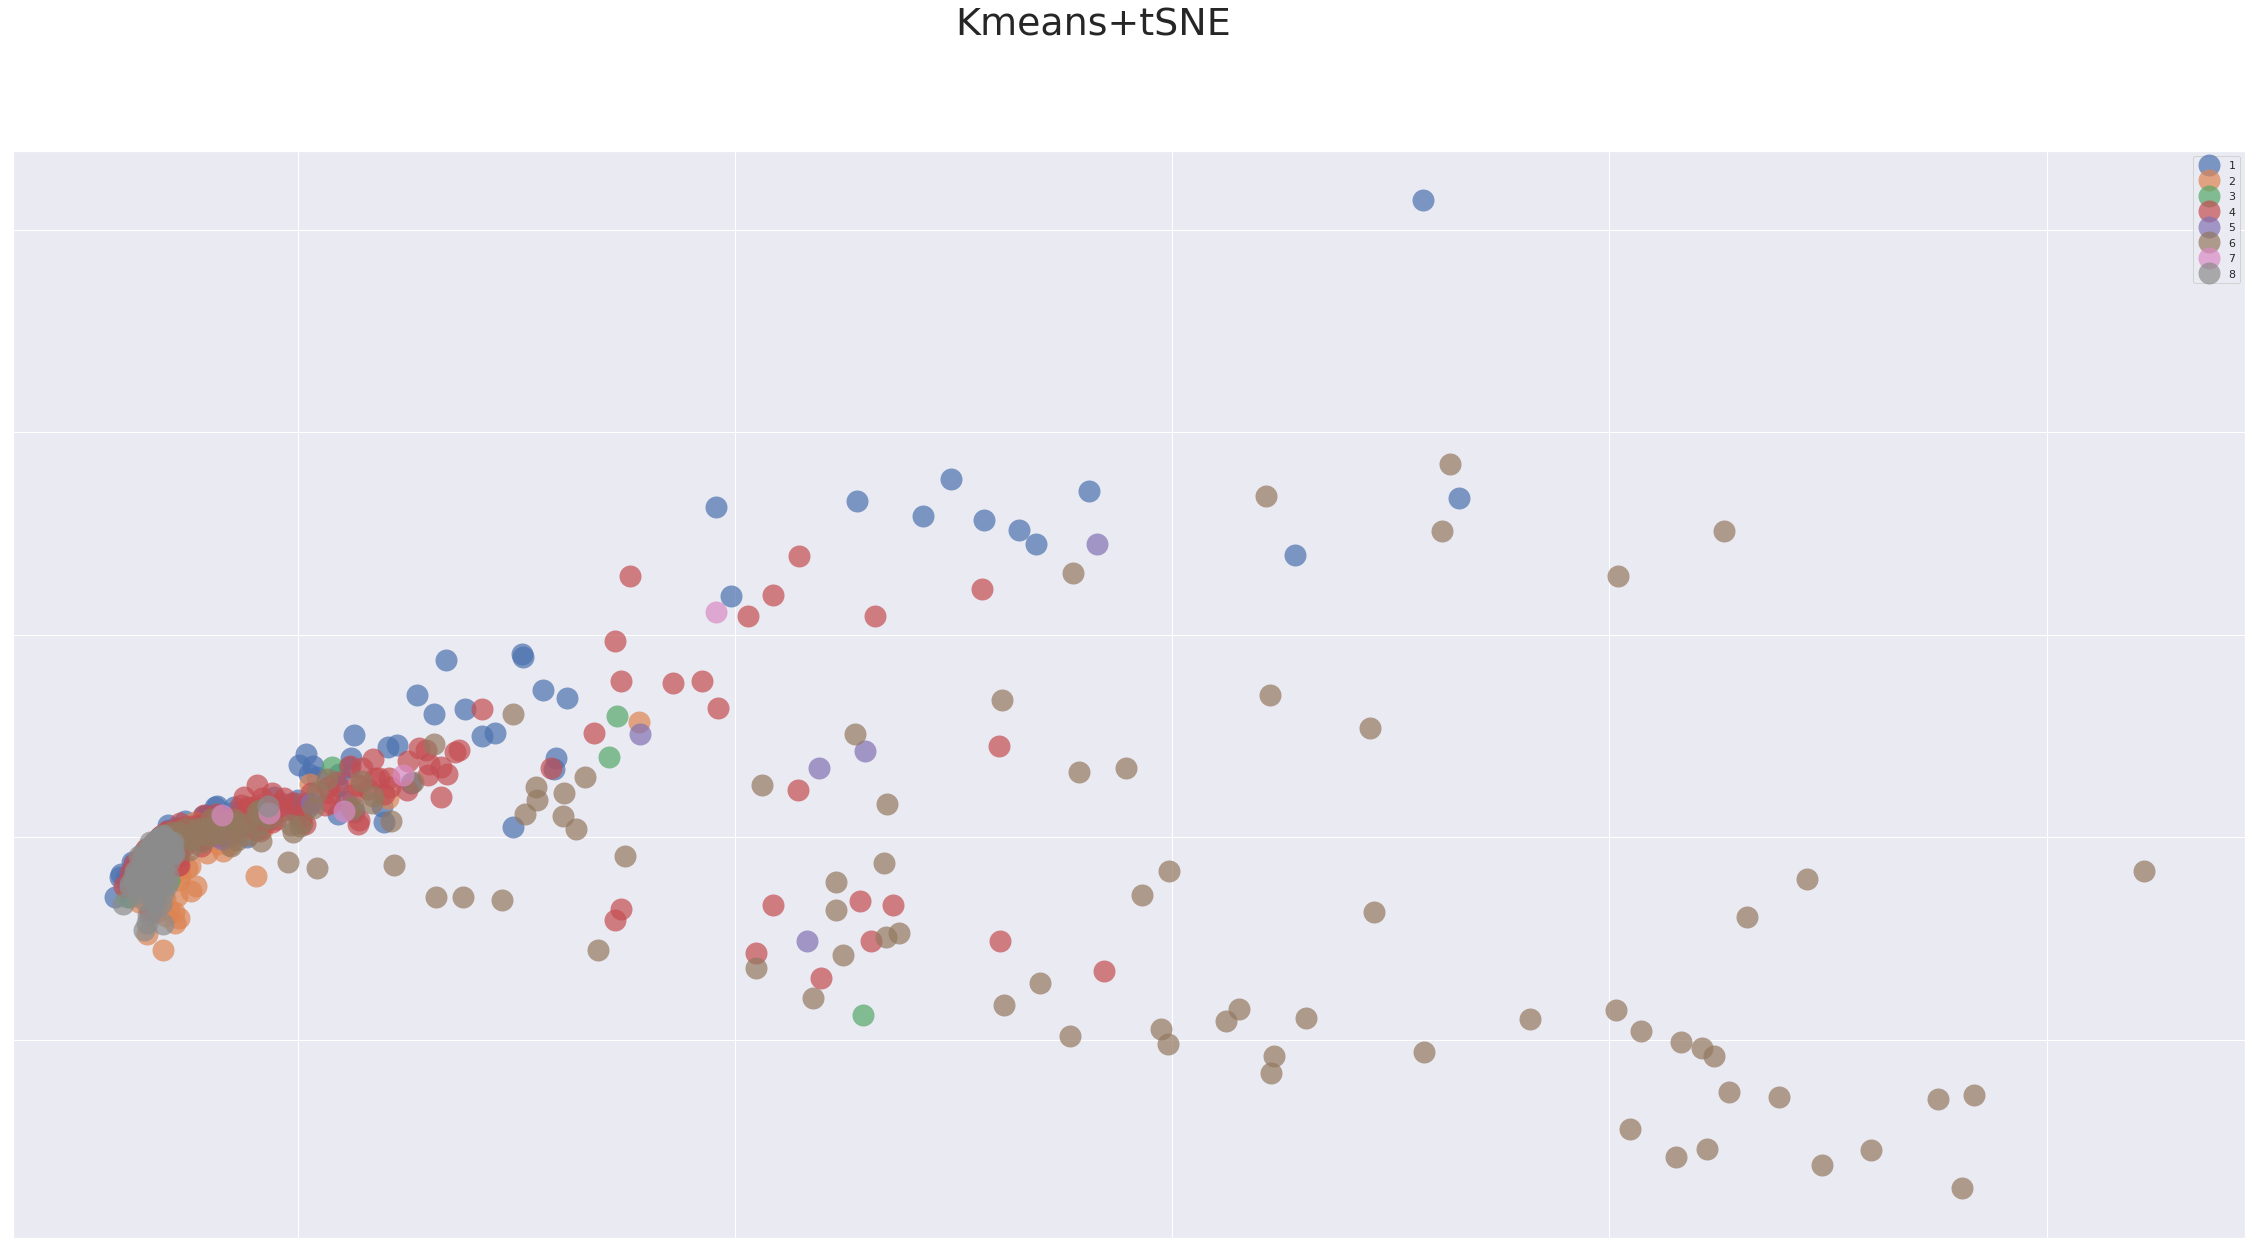

,idn,a02_trad,tSNE_label,tSNE1,tSNE2
0,1,Bushmen,3,-5.449046,0.559562
1,2,Khoikhoi,3,-3.131956,0.176222
2,3,Xhosa,5,-2.762295,-0.220902
3,4,"Zulu,Swasi",3,-4.039606,0.922487
4,5,"Sotho, Tswana",5,-2.250557,0.248442
5,6,"Tonga, Ndebele",5,-3.894768,0.993513
6,7,Shona,5,-1.764166,1.218162
7,8,"Bemba,Kaonde,Lamba",3,-4.446332,1.045217
8,9,"Tsonga,Soli,Sala,Lenje",5,-3.599328,0.659439
9,10,Ila,5,-5.776440,0.328016


In [59]:
plot_emd('tSNE',X_tsne,8)

### Hierarchy

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram

# font = {'family' : 'Verdana', 'weight': 'normal', 'size'   : 22}
# rc('font', **font)

def plot_heirarchy(data, method = None):
    linkage_matrix = ward(data)

    fig, ax = plt.subplots(figsize=(20, 20))
    ax = dendrogram(linkage_matrix, orientation="left");
    # ax.text(size=22)
    plt.tick_params(\
        axis= 'x',
        which='both', 
        bottom='off',
        top='on',
        labelbottom='off')

    plt.tight_layout() 

    fig.suptitle(str(method)+'Hierarchy', fontsize=16)
# fig.savefig('answ3_hierarchy.jpg')

plot_heirarchy(x)

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


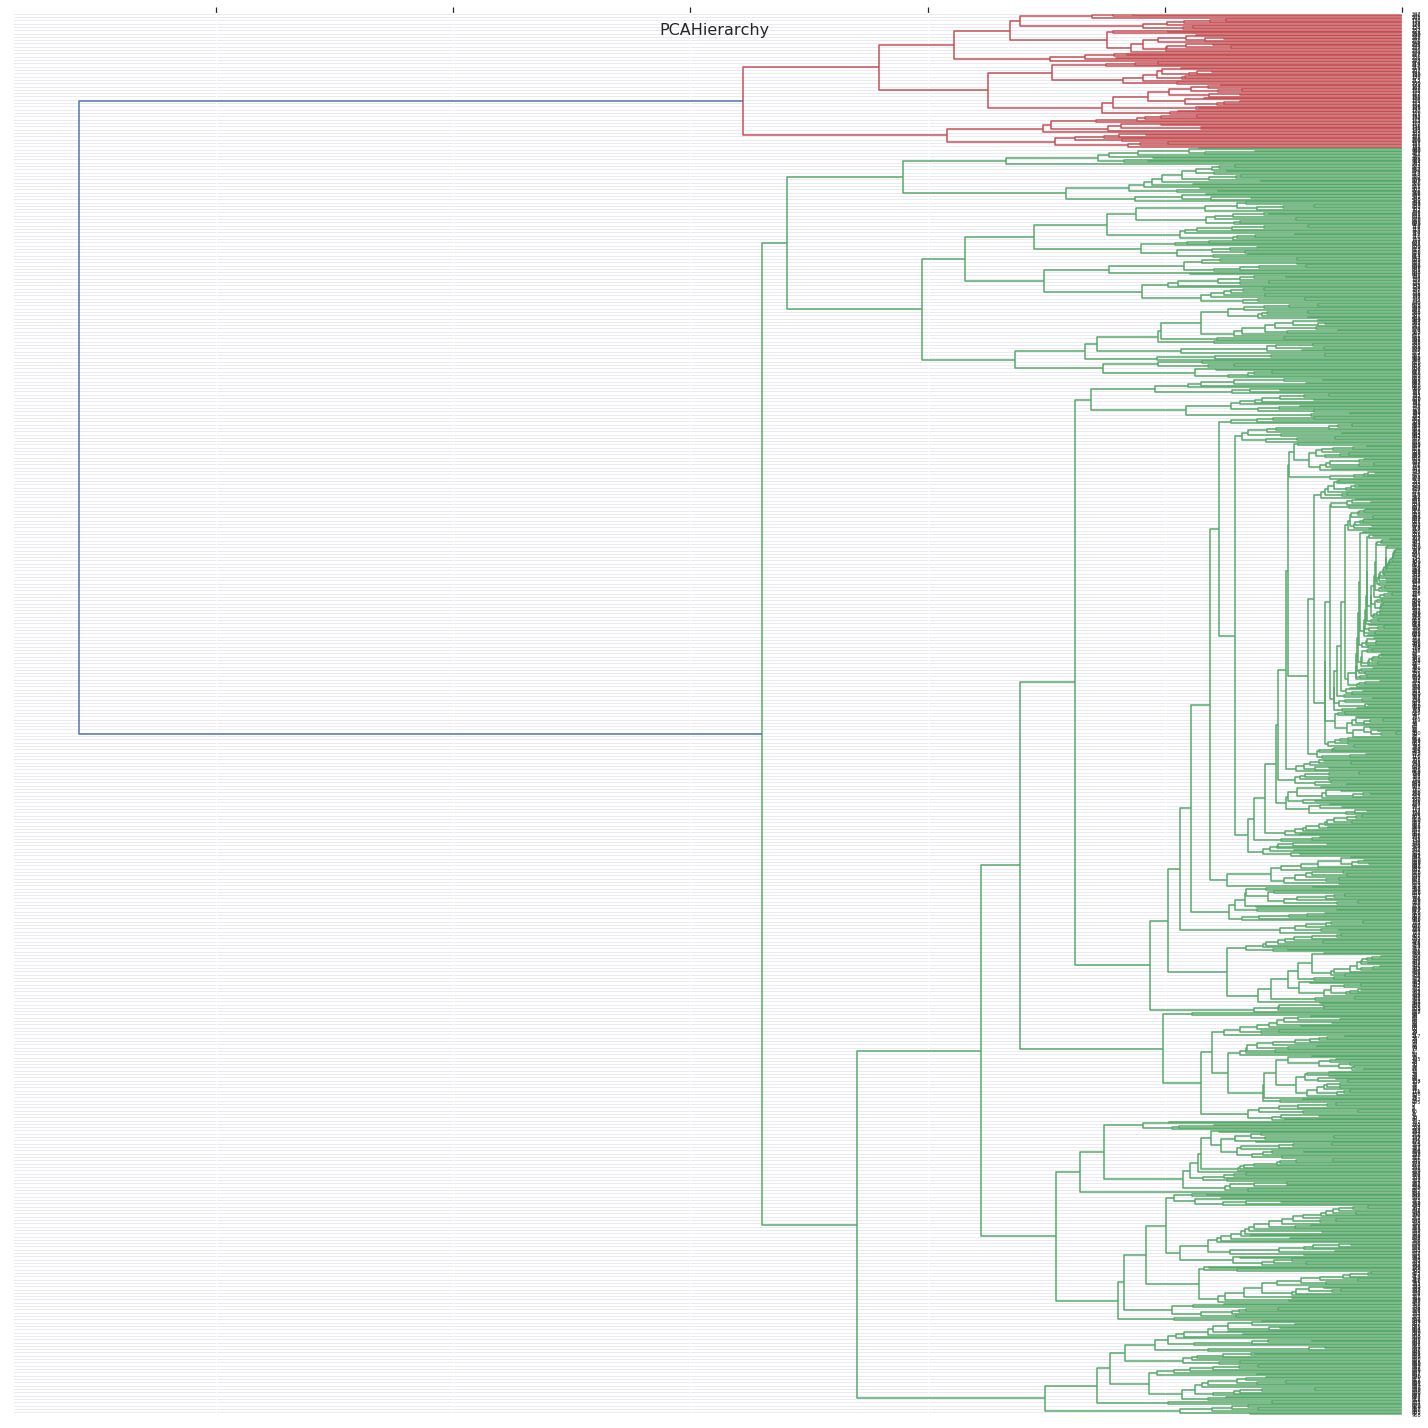

In [54]:
plot_heirarchy(x_pca, method = "PCA")

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


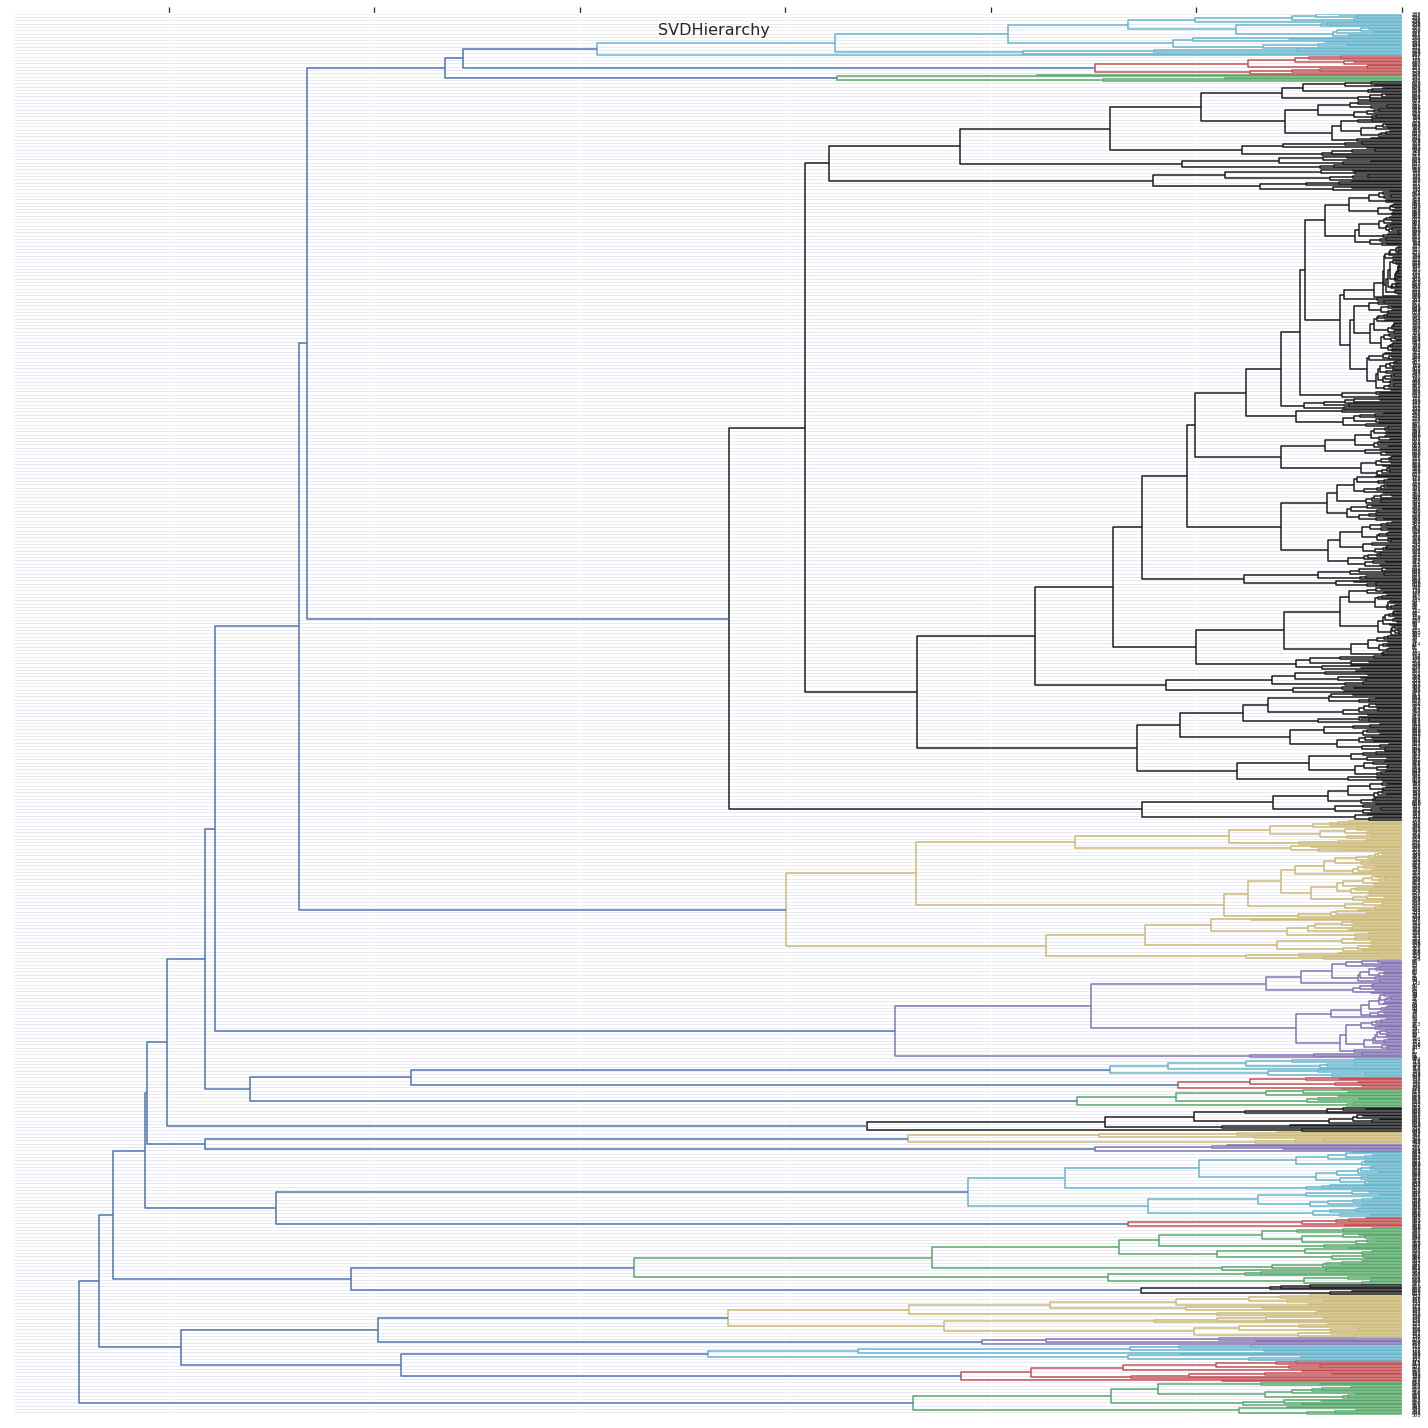

In [60]:
plot_heirarchy(newdata, method = "SVD")

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


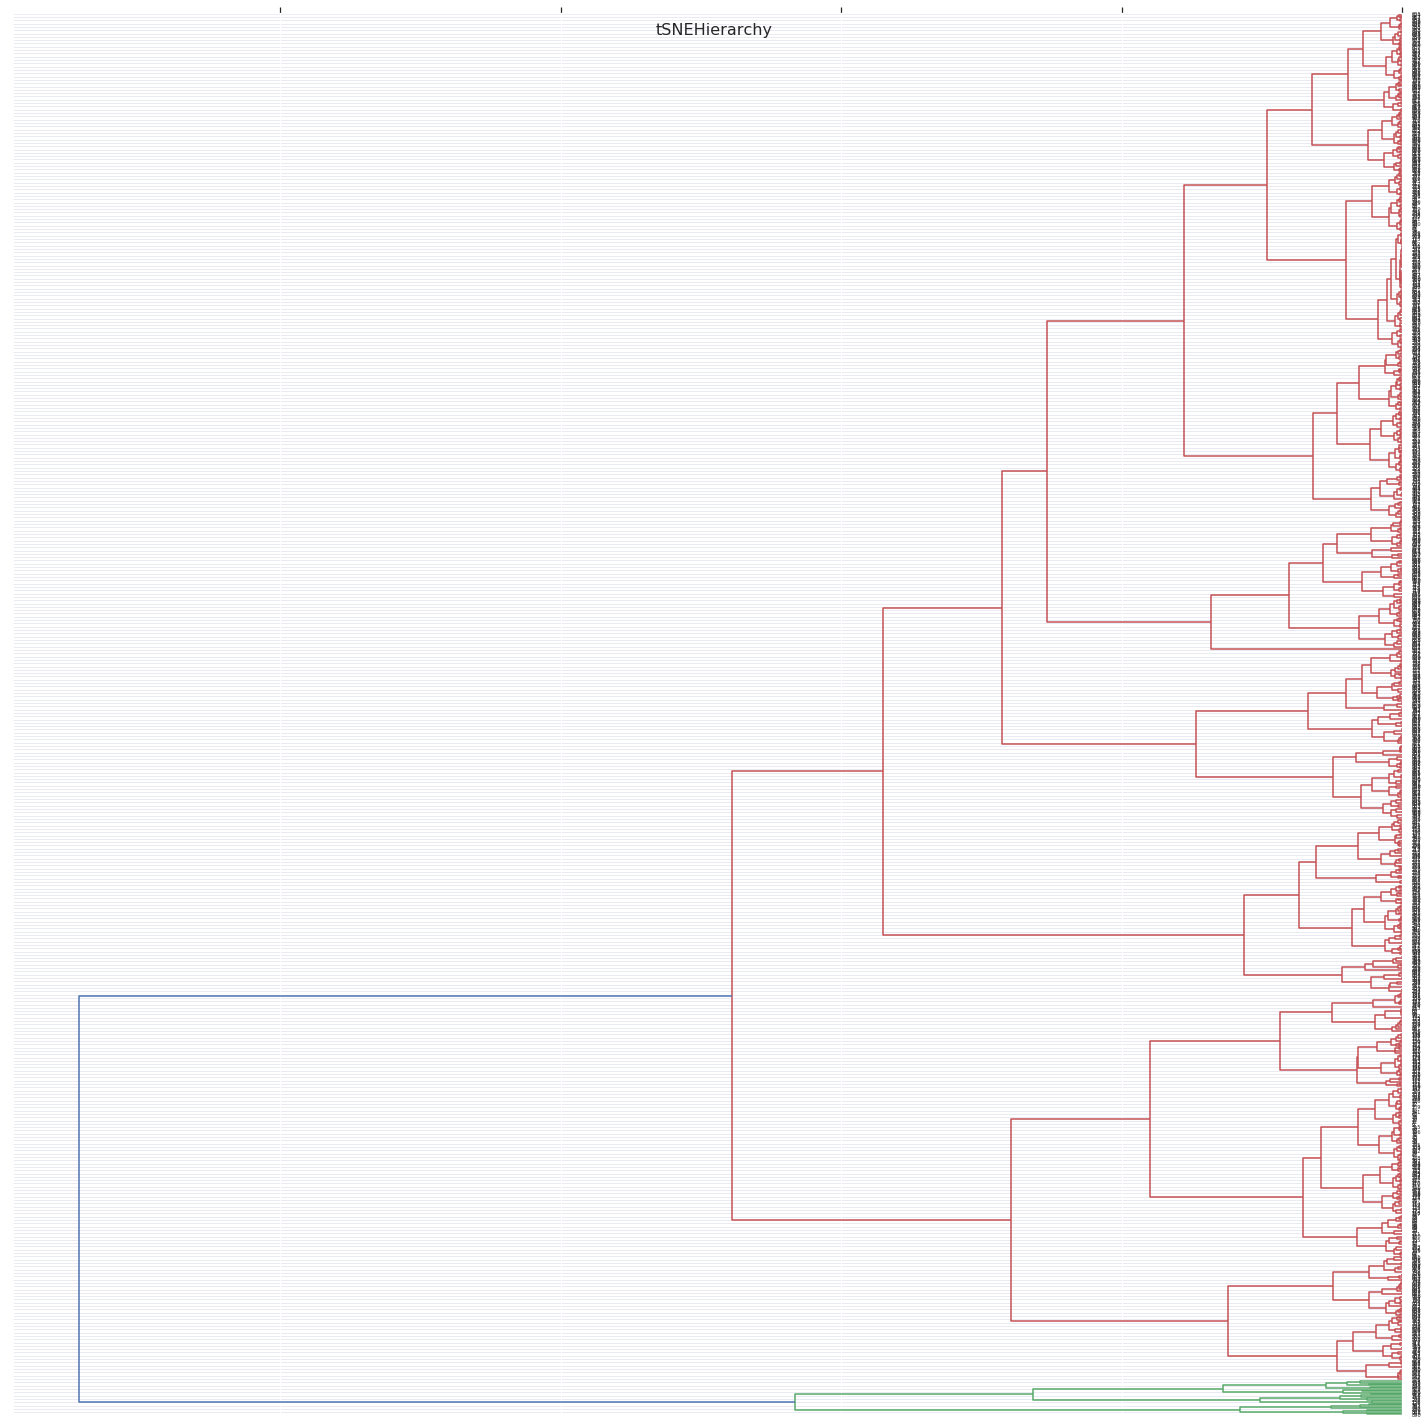

In [55]:
plot_heirarchy(X_tsne, method = "tSNE")

/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/andrey/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0.98,'Hierarchy')

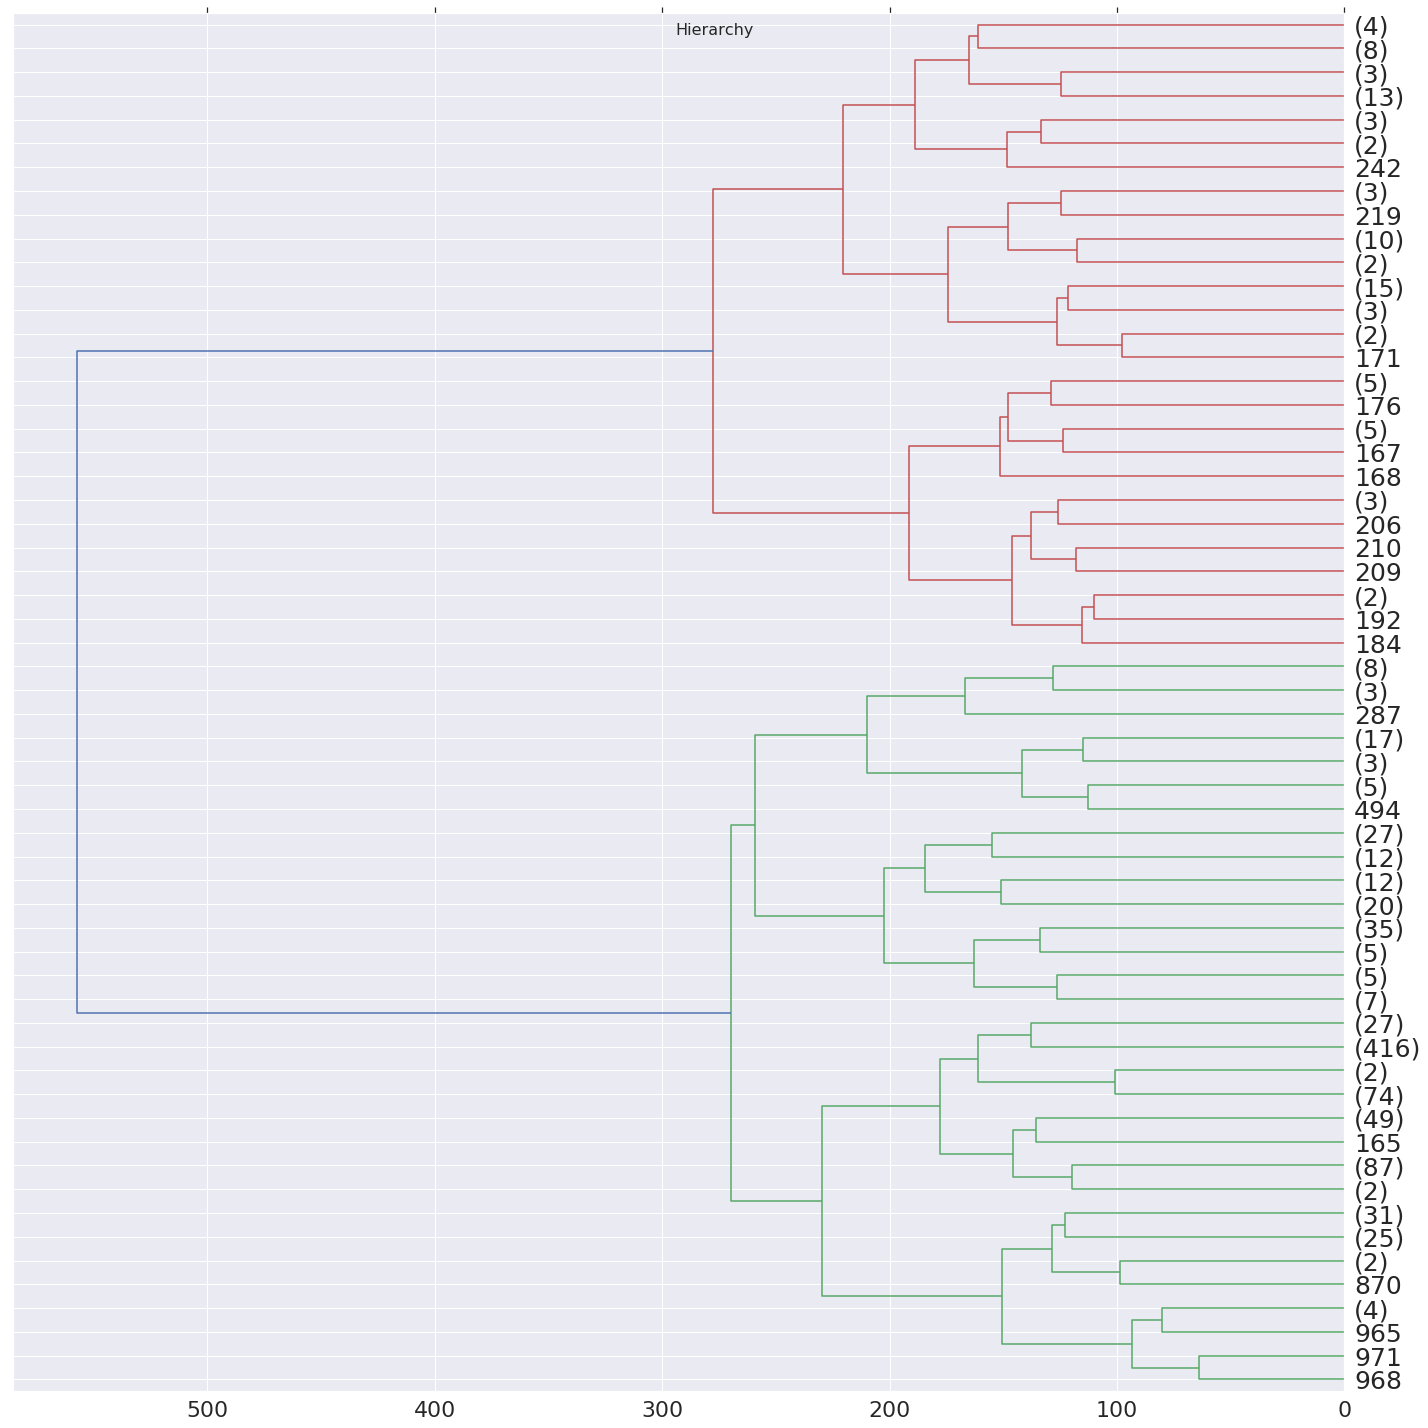

In [56]:
#truncate+increase font

linkage_matrix = ward(x_pca)

fig, ax = plt.subplots(figsize=(20, 20))
ax = dendrogram(linkage_matrix, orientation="left", truncate_mode='level', p =5);

plt.tick_params(\
    axis= 'x',
    which='both', 
    bottom='off',
    top='on',
#     labelbottom='off',
    labelsize=22)
plt.tick_params(\
    axis= 'y',
    labelsize=25)

# ax.tick_params(axis='y', which='major', labelsize=8)
plt.tight_layout() 

fig.suptitle('Hierarchy', fontsize=16)